In [26]:
%run srcnn.py
%matplotlib inline

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11585601164189359386
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11807021466
locality {
  bus_id: 1
}
incarnation: 14898876662771865642
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 12050268160
locality {
  bus_id: 2
}
incarnation: 17387685730516867947
physical_device_desc: "device: 1, name: GeForce GTX TITAN X, pci bus id: 0000:83:00.0, compute capability: 5.2"
]
['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1']


### Load images

In [4]:
PATH = "datasets"
TRAIN_FILE = "datasets/DIV2K_train_HR/"

In [5]:
obj_files = listdir(TRAIN_FILE )
imgs = []

for i in range(0,90):
    n = obj_files[i]
    imgs.append(np.asarray(Image.open(TRAIN_FILE + n)))

90


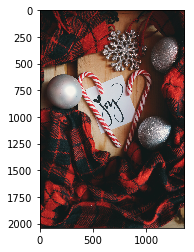

In [6]:
print(len(imgs))

plt.imshow(imgs[0])

### Generate train and test set
In the training phase, the ground truth images {Xi } are prepared as 32 × 32-
sub-images. To synthesize the low-resolution samples {Yi}, we blur a sub-image by a proper Gaussian kernel, sub-sample it by the upscaling factor, and upscale it by the same factor via bicubic interpolation. 
The sub-images are extracted from original images with a stride of 14.

#### Original image and bicubic interpolated image

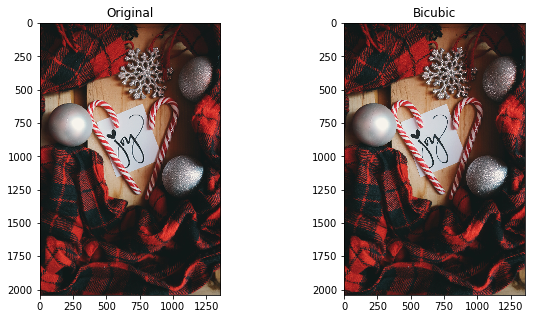

In [7]:
sample, label = get_input_images(imgs[0],  scale = 4 )
plot_images([sample, label], ["Bicubic", "Original"])

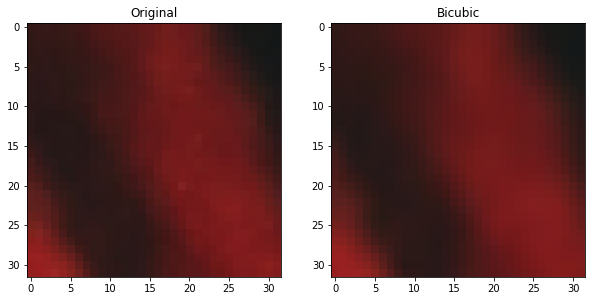

In [8]:
smp, ptch = generate_patches(imgs[0])

img_size = utility.getSize(smp[0])[0]
plot_images([smp[10], ptch[10]], ["Bicubic", "Original"])

#### Example of our train and test set images

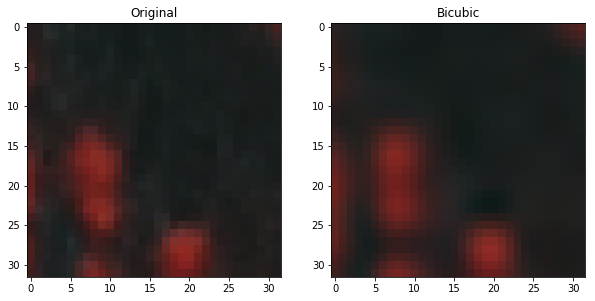

In [9]:
samples_list, labels_list = image_patches(imgs,  scale = 4)

#img_size = utility.getSize(labels[0])[0]

plot_images([samples_list[500], labels_list[500]], ["Bicubic", "Original"])

In [10]:
index = [i for i in range(len(samples_list))]
random.shuffle(index)

samples = np.asarray(samples_list)
labels = np.asarray(labels_list)

samples = samples
labels = labels


In [11]:
train, test = normalize(samples, labels)

### Convolutional Neural Networks

In [12]:
model = srcnn_mode()
srcnn_compile(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        36928     
__________

In [14]:
batch_size = 64
epochs = 50

def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

change_lr = LearningRateScheduler(step_decay)

model.fit(train, test,
          epochs=epochs,
          verbose=1,
          batch_size=batch_size,
          validation_split = 0.2)

Train on 996940 samples, validate on 249236 samples
Epoch 1/20
996940/996940 [==============================] - 859s 862us/step - loss: 0.0049 - psnr: 55.5355 - val_loss: 0.0047 - val_psnr: 64.5446
Epoch 2/20
996940/996940 [==============================] - 860s 863us/step - loss: 0.0039 - psnr: 56.6315 - val_loss: 0.0046 - val_psnr: 64.5630
Epoch 3/20
996940/996940 [==============================] - 866s 869us/step - loss: 0.0037 - psnr: 56.7712 - val_loss: 0.0045 - val_psnr: 64.8645
Epoch 4/20
996940/996940 [==============================] - 857s 860us/step - loss: 0.0037 - psnr: 56.8589 - val_loss: 0.0044 - val_psnr: 64.6921
Epoch 5/20
996940/996940 [==============================] - 858s 861us/step - loss: 0.0036 - psnr: 56.9260 - val_loss: 0.0044 - val_psnr: 64.8627
Epoch 6/20
996940/996940 [==============================] - 866s 869us/step - loss: 0.0036 - psnr: 56.9840 - val_loss: 0.0044 - val_psnr: 64.5503
Epoch 7/20
996940/996940 [==============================] - 866s 868us/s

In [23]:
name = "sptial_deep_model"
save_model(model, name)

In [16]:
TEST_FILE5 = "datasets/SR_Test/Set5/"
def get_test_dataset(test_name = TEST_FILE5) :
    vald_pil = load_images([TEST_FILE5 ])
    return vald_pil


(256, 256, 3)


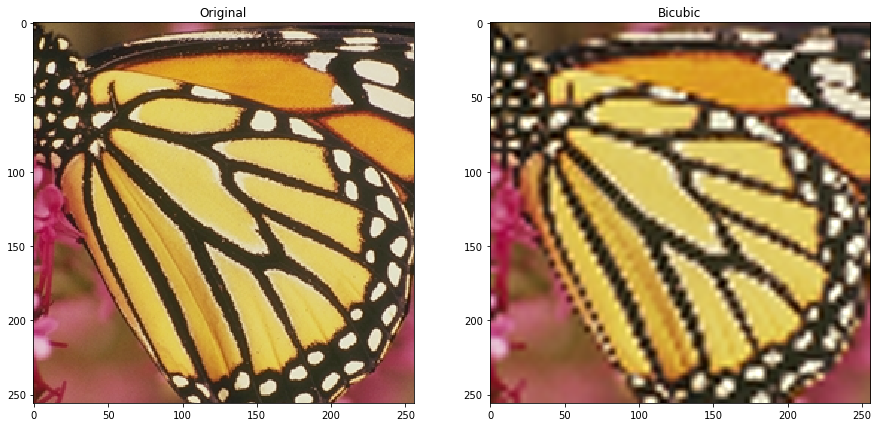

In [17]:
vald_pil = get_test_dataset()
val_img = vald_pil[id]

org, bicubic = get_input_images(val_img, 4)

print(bicubic.shape)
plot_images([bicubic, org], ["Bicubic", "Original"], size=(15,10))

In [17]:
val_img.shape

(256, 256, 3)

In [18]:
#plt.imshow(im[0])

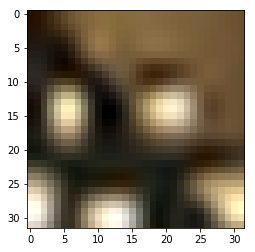

In [19]:
subBic, subOrg = generate_patches(val_img, 
                                  patch_size = 32, 
                                  label_size = 32, 
                                  scale = 4, 
                                  stride = 30 )
    
    
subBic = np.asarray(subBic)
subOrg = np.asarray(subOrg)


subOrg, subBic = normalize(subOrg, subBic)

plt.imshow(subBic[0])

In [20]:
pred = model.predict(subBic, 64)
pred = pred.clip(0,1)
pred.shape

(64, 32, 32, 3)

In [21]:
h, w = utility.getSize(val_img)
image = patch_to_image(pred, h, w, 0, 32, 32, stride=30)

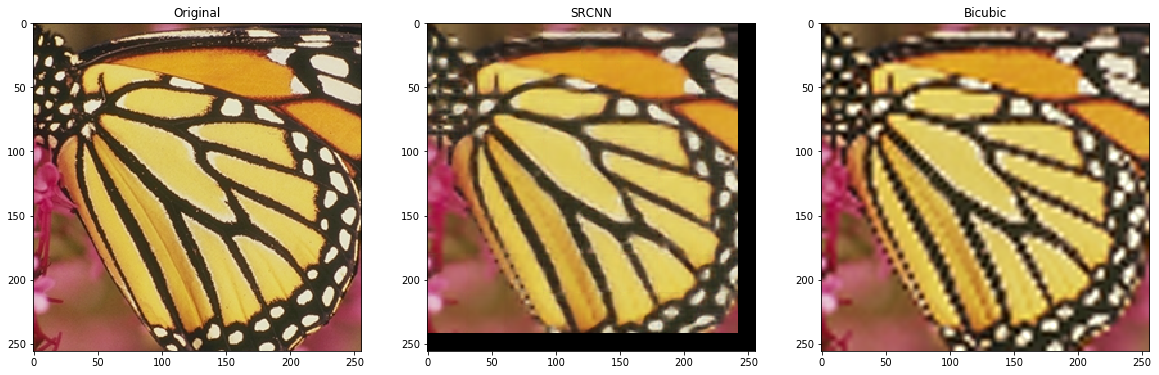

In [22]:
plot_images([bicubic, val_img, image], ["Bicubic", "Original", "SRCNN"], size=(20, 10))

### test.shape

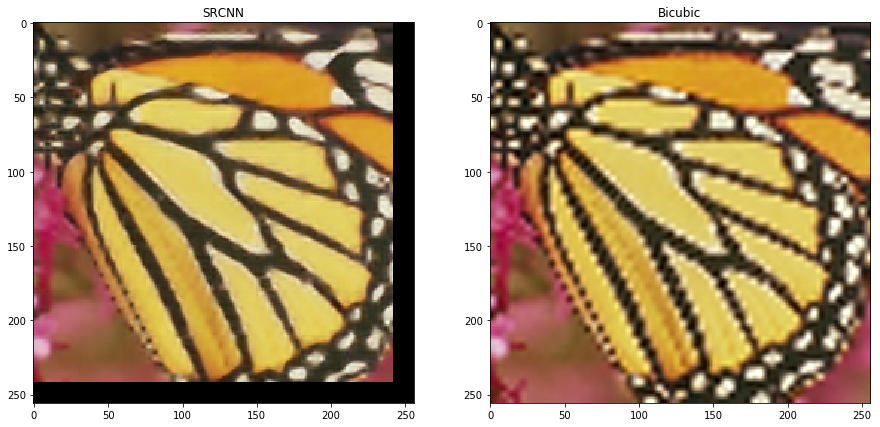

In [24]:
plot_images([bicubic, image], ["Bicubic", "SRCNN"], size=(15, 10))

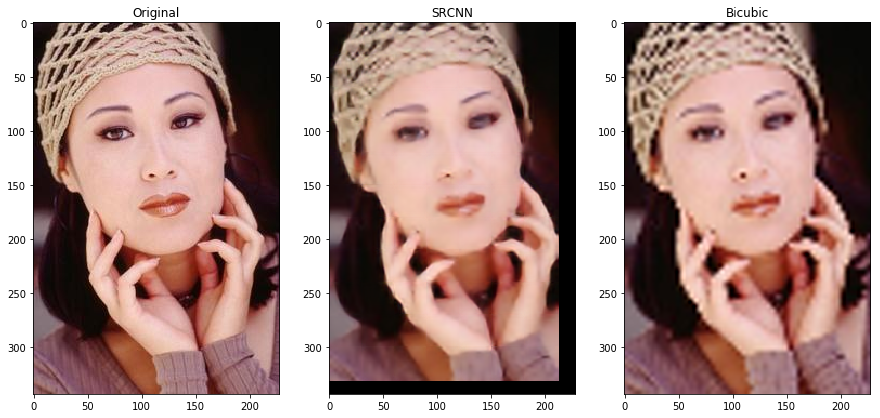

In [37]:
id = 0
val_img = vald_pil[id]

org, bic = get_input_images(val_img, 4)
subBic, subOrg = generate_patches(val_img, 
                                  patch_size = 32, 
                                  label_size = 32, 
                                  scale = 4, 
                                  stride = 30 )
    
    
subBic = np.asarray(subBic)
subOrg = np.asarray(subOrg)

subOrg, subBic = normalize(subOrg, subBic)

pred = model.predict(subBic, 64)
pred = pred.clip(0,1)

h, w = utility.getSize(val_img)
image = patch_to_image(pred, h, w, 0, 32, 32, stride=30)

plot_images([bic, org, image], ["Bicubic", "Original", "SRCNN"], size=(15, 15))

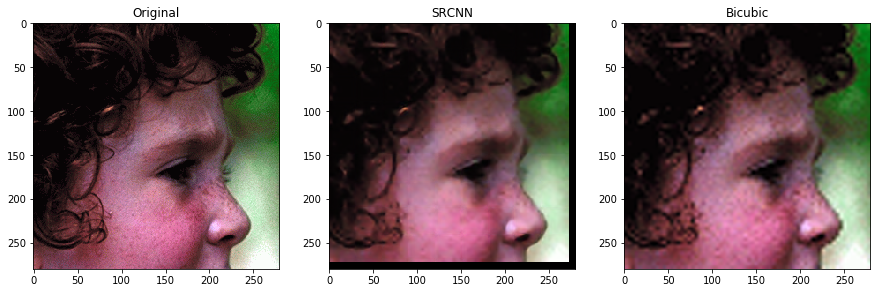

In [38]:
id = 2
val_img = vald_pil[id]

org, bic = get_input_images(val_img, 4)
subBic, subOrg = generate_patches(val_img, 
                                  patch_size = 32, 
                                  label_size = 32, 
                                  scale = 4, 
                                  stride = 30 )
    
    
subBic = np.asarray(subBic)
subOrg = np.asarray(subOrg)

subOrg, subBic = normalize(subOrg, subBic)

pred = model.predict(subBic, 64)
pred = pred.clip(0,1)

h, w = utility.getSize(val_img)
image = patch_to_image(pred, h, w, 0, 32, 32, stride=30)

plot_images([bic, org, image], ["Bicubic", "Original", "SRCNN"], size=(15, 15))

In [35]:
plot_images([bic, image], ["Bicubic", "SRCNN"], size=(15, 10))

# Load model

In [14]:
name = "sptial_deep_model"
#save_model(model, name)

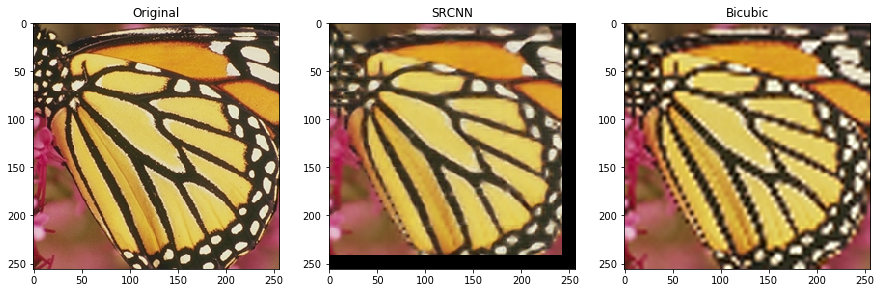

In [27]:
id = 3
l_model = load_model(name)

vald_pil = get_test_dataset()
img = vald_pil[id]

org, bic = get_input_images(img)
image = predict_image(l_model, img, stride=30)

plot_images([bic, org, image], ["Bicubic", "Original", "SRCNN"], size=(15, 15))